# Peak spreading analysis

In transportation planning, the percentage of AADT that occurs during the peak is referred to as the K factor, and the standard for planning analyses is 9%. Relatedly, the D factor is the directional distribution, standard is 55%.

In [31]:
#using Revise # handy for development but breaks multithreading
using CSV, Parquet, DataFrames, Plots, Dates, CategoricalArrays, Missings, Random, Statistics, StatsBase, Glob, Latexify, KFactors, FreqTables, Pipe,
    ThreadsX, GLM, RegressionTables, LinearAlgebra

import Base.Threads: @spawn

In [32]:
full_data = read_data("../data/peaks_merged.parquet");

┌ Info: Removing sensors days with peak-hour occ above 99th percentile (22.83%)
└ @ KFactors C:\Users\mwbc\git\peak-spreading\src\computation.jl:65


In [33]:
data = KFactors.create_test_data(full_data, KFactors.Periods.SPRING_2022);

In [34]:
length(unique(data.station))

3691

# Overall congestion

In [35]:
# https://identity.unc.edu/brand/color-palette/
const UNC_BLUE = RGB(75/255, 156/255, 211/255)
const UNC_NAVY = RGB(19/255, 41/255, 75/255)
const UNC_DAVIE_GREEN = RGB(196/255, 214/255, 0/255)
const UNC_PINK = RGB(239/255, 68/255, 111/255)

In [ ]:
# unweighted
prex, prey = KFactors.cumulative_dist(data.peak_hour_occ[coalesce.(data.period .== :prepandemic, false)])
durx, dury = KFactors.cumulative_dist(data.peak_hour_occ[coalesce.(data.period .== :lockdown, false)])
postx, posty = KFactors.cumulative_dist(data.peak_hour_occ[coalesce.(data.period .== :postlockdown, false)])

plot(prex .* 100, prey .* 100, linecolor=UNC_BLUE, label="Pre-pandemic", xlim=[1/24, 0.25] .* 100, legend=:bottomright,
        xlabel="Percent of daily occupancy in the peak hour", ylabel="Percent of sensors", linewidth=2)

plot!(postx .* 100, posty .* 100, linecolor=UNC_NAVY, label="Post-lockdown", linewidth=2)
savefig("../fig/cumulative_dist_prepost.pdf")

plot!(durx .* 100, dury .* 100, linecolor=UNC_PINK, label="Lockdown", linewidth=2)
savefig("../fig/cumulative_dist.pdf")

plot!()


In [ ]:
prex, prey = KFactors.cumulative_dist(data.occ_entropy[coalesce.(data.period .== :prepandemic, false)])
durx, dury = KFactors.cumulative_dist(data.occ_entropy[coalesce.(data.period .== :lockdown, false)])
postx, posty = KFactors.cumulative_dist(data.occ_entropy[coalesce.(data.period .== :postlockdown, false)])

plot(prex .* 100, prey .* 100, linecolor=UNC_BLUE, label="Pre-pandemic", legend=:bottomright, xlim=[700, 820],
        xlabel="Occupancy entropy (centibits)", ylabel="Percent of sensors", linewidth=2)
plot!(postx .* 100, posty .* 100, linecolor=UNC_NAVY, label="Post-lockdown", linewidth=2)

savefig("../fig/cumulative_dist_entropy_prepost.pdf")

plot!(durx .* 100, dury .* 100, linecolor=UNC_PINK, label="Lockdown", linewidth=2)
savefig("../fig/cumulative_dist_entropy.pdf")

plot!()

In [ ]:
prex, prey = KFactors.cumulative_dist(data.occ_entropy_daytime[coalesce.(data.period .== :prepandemic, false)])
durx, dury = KFactors.cumulative_dist(data.occ_entropy_daytime[coalesce.(data.period .== :lockdown, false)])
postx, posty = KFactors.cumulative_dist(data.occ_entropy_daytime[coalesce.(data.period .== :postlockdown, false)])

plot(prex .* 100, prey .* 100, linecolor=UNC_BLUE, label="Pre-pandemic", legend=:topleft, xlim=[680, 750],
        xlabel="Daytime occupancy entropy (centibits)", ylabel="Percent of sensors", linewidth=2)
plot!(durx .* 100, dury .* 100, linecolor=UNC_PINK, label="Lockdown", linewidth=2)
plot!(postx .* 100, posty .* 100, linecolor=UNC_NAVY, label="Post-lockdown", linewidth=2)

savefig("../fig/cumulative_dist_daytime_entropy.pdf")

plot!()

In [ ]:
prex, prey = KFactors.cumulative_dist(data.hours_of_congestion[coalesce.(data.period .== :prepandemic, false)])
durx, dury = KFactors.cumulative_dist(data.hours_of_congestion[coalesce.(data.period .== :lockdown, false)])
postx, posty = KFactors.cumulative_dist(data.hours_of_congestion[coalesce.(data.period .== :postlockdown, false)])

# remove step-function look
prey = prey[prex .!= circshift(prex, 1)]
prex = prex[prex .!= circshift(prex, 1)]
dury = dury[durx .!= circshift(durx, 1)]
durx = durx[durx .!= circshift(durx, 1)]
posty = posty[postx .!= circshift(postx, 1)]
postx = postx[postx .!= circshift(postx, 1)]

plot(prex, prey, linecolor=UNC_BLUE, label="Pre-pandemic", legend=:bottomright,
        xlabel="Hours of congestion", ylabel="Percent of sensors", linewidth=2)
plot!(durx, dury, linecolor=UNC_PINK, label="Lockdown", linewidth=2)
plot!(postx, posty, linecolor=UNC_NAVY, label="Post-lockdown", linewidth=2)

savefig("../fig/cumulative_dist_hours_of_congestion.pdf")

plot!()

## Histogram of changes

Overall traffic is less peaky, but there's a distribution.

In [37]:
@assert !any(ismissing.(data.period))
peak_changes = combine(groupby(data, [:station, :period]), :peak_hour_occ => mean)
peak_changes = unstack(peak_changes, :station, :period, :peak_hour_occ_mean)
nothing

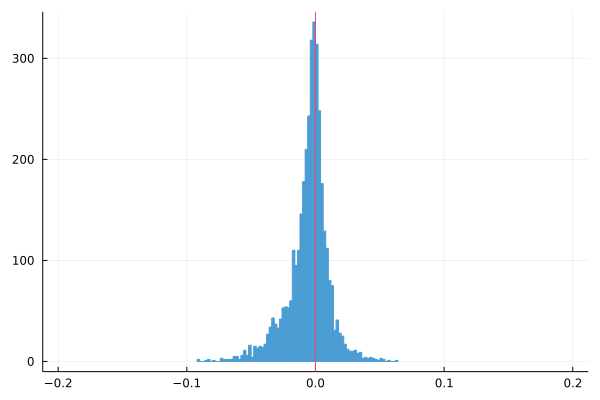

In [38]:
peak_changes.mean_change = peak_changes.postlockdown .- peak_changes.prepandemic
histogram(collect(skipmissing(peak_changes.mean_change)), xlim=[-0.2, 0.2], fillcolor=UNC_BLUE, linecolor=UNC_BLUE, legend=false)
vline!([0], color=UNC_PINK)

In [39]:
"Perform tests using all relevant variables"
function all_tests(label, data)
    permutations = 1000
    occ = permutation_test(data, :peak_hour_occ, n_permutations=permutations)
    flow = permutation_test(data, :peak_hour_flow, n_permutations=permutations)
    entr = permutation_test(data, :occ_entropy, n_permutations=permutations)
    daytime_entr = permutation_test(data, :occ_entropy_daytime, n_permutations=permutations)
    hour = permutation_test(data, :hours_of_congestion, n_permutations=permutations)
    traffic_volume = permutation_test(data, :total_flow, n_permutations=permutations)
    
    @assert occ.n_sensors == flow.n_sensors
    @assert occ.n_sensors == entr.n_sensors
    @assert occ.n_sensors == daytime_entr.n_sensors
    @assert occ.n_sensors == hour.n_sensors
    @assert occ.n_sensors == traffic_volume.n_sensors
    
    return (
        label=label,
        occ_ts=occ.ptest,
        occ_p=occ.pval,
        flow_ts=flow.ptest,
        flow_p=flow.pval,
        entr_ts=entr.ptest,
        entr_p=entr.pval,
        entr_day_ts=daytime_entr.ptest,
        entr_day_p=daytime_entr.pval,
        hours_ts=hour.ptest,
        hours_p=hour.pval,
        volume_ts=traffic_volume.ptest,
        volume_p=traffic_volume.pval,
        n_sensors=occ.n_sensors
        )
end

all_tests

In [41]:
data_prepost = data[data.period .∈ Ref(Set([:prepandemic, :postlockdown])),:];

In [42]:
transform!(
    groupby(data_prepost, :station),
    [:period, :total_flow] => ((period, flow) -> mean(flow[period .== :postlockdown]) / mean(flow[period .== :prepandemic])) => :station_Δ_flow
    );
    
        

In [43]:
data_prepost.urban = convert(Vector{Bool}, data_prepost.urban); ## remove Missing from eltype

In [44]:
summer_2021_data = KFactors.create_test_data(full_data, KFactors.Periods.SUMMER_2021)
summer_2021_data = summer_2021_data[summer_2021_data.period .!= :lockdown, :]
march_2022_data = KFactors.create_test_data(full_data, KFactors.Periods.MARCH_2022)
march_2022_data = march_2022_data[march_2022_data.period .!= :lockdown, :];

In [47]:
# Filter to just data that was not imputed at all
@assert maximum(data_prepost.periods_imputed) == 288
nonmissing = data_prepost[data_prepost.periods_imputed .< 288, :]

# furthermore, filter to only sensors nonmissing at least one day in both periods
nonmissing_sensors = intersect(
        Set(nonmissing[nonmissing.period .== :prepandemic, :station]),
        Set(nonmissing[nonmissing.period .== :postlockdown, :station])
    )

nonmissing = nonmissing[nonmissing.station .∈ Ref(nonmissing_sensors), :];

In [48]:
half_complete = KFactors.create_test_data(full_data, KFactors.Periods.SPRING_2022; min_complete=0.5)
three_quarters_complete = KFactors.create_test_data(full_data, KFactors.Periods.SPRING_2022; min_complete=0.75)
ninety_five_pct_complete = KFactors.create_test_data(full_data, KFactors.Periods.SPRING_2022; min_complete=0.95)
all_sensors = KFactors.create_test_data(full_data, KFactors.Periods.SPRING_2022; min_complete=0);

In [49]:
ENV["COLUMNS"] = 120

@time permutation_tests = DataFrame(fetch.([
    @spawn(all_tests("Overall", data_prepost)),
    @spawn(all_tests("Urban", data_prepost[data_prepost.urban, :])),
    @spawn(all_tests("Rural", data_prepost[.!data_prepost.urban, :])),
    @spawn(all_tests("District 3 (Sacramento)", data_prepost[data_prepost.District .== 3, :])),
    @spawn(all_tests("District 10 (Stockton)", data_prepost[data_prepost.District .== 10, :])),
    @spawn(all_tests("District 4 (San Francisco Bay Area)", data_prepost[data_prepost.District .== 4, :])),
    @spawn(all_tests("District 5 (Central Coast)", data_prepost[data_prepost.District .== 5, :])),
    # The Freakersfield district
    @spawn(all_tests("District 6 (Fresno / Bakersfield)", data_prepost[data_prepost.District .== 6, :])),
    @spawn(all_tests("District 7 (Los Angeles)", data_prepost[data_prepost.District .== 7, :])),
    @spawn(all_tests("District 12 (Orange County)", data_prepost[data_prepost.District .== 12, :])),
    @spawn(all_tests("District 8 (Inland Empire)", data_prepost[data_prepost.District .== 8, :])),
    @spawn(all_tests("District 11 (San Diego)", data_prepost[data_prepost.District .== 11, :])),

    # robustness checks
    @spawn(all_tests("Sensors that increased in flow", data_prepost[data_prepost.station_Δ_flow .> 1, :])),
    @spawn(all_tests("Sensors that decreased in flow", data_prepost[data_prepost.station_Δ_flow .< 1, :])),
    @spawn(all_tests("Relative to 2019 only", data_prepost[in.(Dates.year.(data_prepost.date), Ref(Set([2019, 2022]))), :])),
    @spawn(all_tests("March 12-August 18 post-lockdown", march_2022_data)),
    @spawn(all_tests("Summer 2021 post-lockdown", summer_2021_data)),
    @spawn(all_tests("No imputed data", nonmissing)),
    @spawn(all_tests("Sensors less than 50% imputed", half_complete[half_complete.period .∈ Ref(Set([:prepandemic, :postlockdown])), :])),
    @spawn(all_tests("Sensors less than 25% imputed", three_quarters_complete[three_quarters_complete.period .∈ Ref(Set([:prepandemic, :postlockdown])), :])),
    @spawn(all_tests("Sensors less than 5% imputed", ninety_five_pct_complete[ninety_five_pct_complete.period .∈ Ref(Set([:prepandemic, :postlockdown])), :])),
    @spawn(all_tests("All sensors", all_sensors[all_sensors.period .∈ Ref(Set([:prepandemic, :postlockdown])), :]))
]))

308.886103 seconds (183.28 M allocations: 13.838 GiB, 6.77% gc time, 1.20% compilation time)


,label,occ_ts,occ_p,flow_ts,flow_p,entr_ts,entr_p,entr_day_ts,entr_day_p
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Overall,-0.00563268,0.0,0.000337921,0.22,0.0265723,0.0,0.0201299,0.0
2,Urban,-0.00582328,0.0,0.00105385,0.0,0.0202415,0.0,0.0182459,0.0
3,Rural,-0.00440554,0.0,-0.00395221,0.0,0.0564299,0.0,0.0292489,0.0
4,District 3 (Sacramento),-0.0118107,0.0,0.000734409,0.01,0.0319509,0.0,0.0320261,0.0
5,District 10 (Stockton),0.0012732,0.0,-0.00715489,0.0,0.100755,0.0,0.0383613,0.0
6,District 4 (San Francisco Bay Area),-0.00620266,0.0,0.00540325,0.0,0.0165862,0.0,0.0197498,0.0
7,District 5 (Central Coast),0.00256064,0.0,0.00270961,0.0,-0.050142,0.0,-0.0033535,0.002
8,District 6 (Fresno / Bakersfield),-0.0013868,0.0,-0.00128745,0.0,0.0131973,0.0,0.00717195,0.0
9,District 7 (Los Angeles),-0.00547976,0.0,0.00156209,0.0,0.0162927,0.0,0.0158788,0.0


In [ ]:
permutation_tests_fmt = permutation_tests[:,Not([:volume_ts, :volume_p])]
permutation_tests_fmt.occ_ts .*= 100
permutation_tests_fmt.flow_ts .*= 100
permutation_tests_fmt.entr_ts .*= 100
permutation_tests_fmt.entr_day_ts .*= 100
permutation_tests_fmt.hours_ts = round.(Int64, permutation_tests_fmt.hours_ts .* 60)


for name in names(permutation_tests_fmt)
    if name ∉ Set(["label", "n_sensors", "hours_ts"])
        permutation_tests_fmt[!, name] = round.(permutation_tests_fmt[!, name], digits=2)
    end
end

permutation_tests_fmt.label = map(permutation_tests_fmt.label) do l
    replace(l, r"District ([0-9]+) \((.*)\)" => s"\2 (D\1)")
end

latexify(permutation_tests_fmt, env=:table, latex=false, booktabs=true)

## Percent change from pre-pandemic

In [50]:
prepandemic_occ = mean(data[data.period .== :prepandemic, :peak_hour_occ])
postlockdown_occ = mean(data[data.period .== :postlockdown, :peak_hour_occ])
(postlockdown_occ - prepandemic_occ) / prepandemic_occ

-0.05461803909297598

In [51]:
prepandemic_occ

0.10312847980146672

In [52]:
# dump only the stations we actually used for mapping
used_station = combine(
    groupby(data, :station),
    :Latitude => last => :Latitude,
    :Longitude => last => :Longitude
)
CSV.write("../data/stations_used_in_analysis.csv", used_station)

"../data/stations_used_in_analysis.csv"